In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
np.random.seed(98765)

## Drew added
import tqdm as tqdm
import random
from sklearn import decomposition
from sklearn.metrics import roc_auc_score, average_precision_score


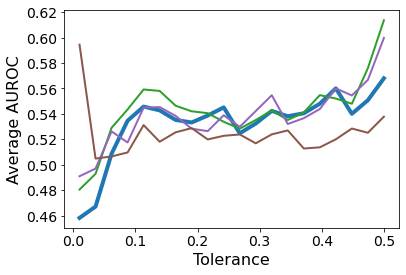

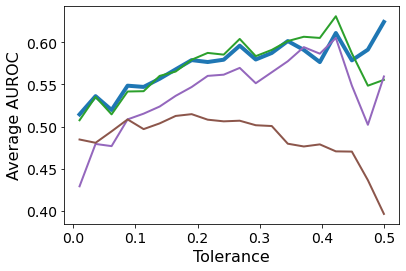

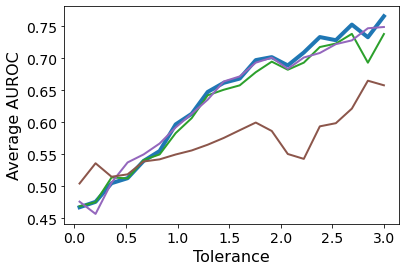

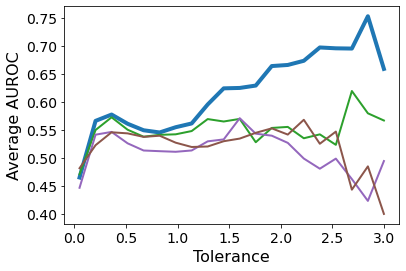

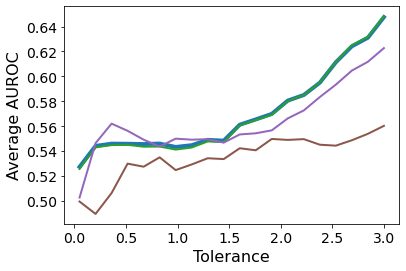

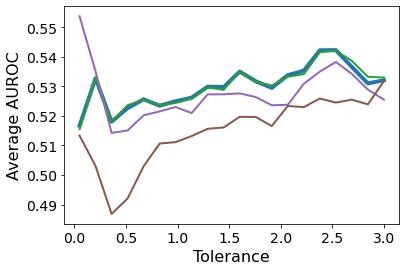

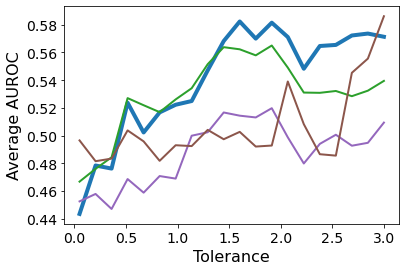

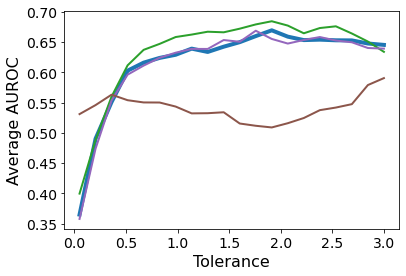

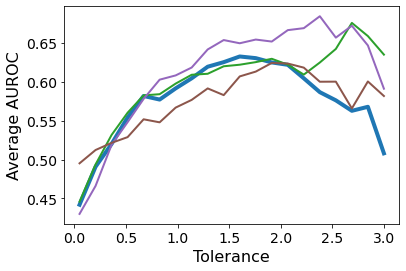

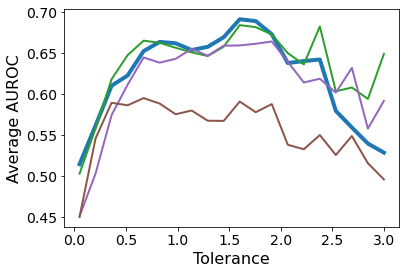

In [4]:
for dataset in ['airfoil', 'wine', 'wave', 'superconduct', 'communities']:
    for mu in ['NN', 'RF']:
        
        AUC_results = pd.read_csv('20220717_AUC_' + str(dataset) + '_' + str(mu) + '_data.csv', index_col = 0)

        plt.figure(figsize=(6,4))
        plt.plot(AUC_results['taus'], AUC_results['JAW'], label = "JAW", color= 'C0', linewidth=4)
        plt.plot(AUC_results['taus'], AUC_results['jackknife+'], label = "Jackknife+", color = 'C2', linewidth=2)
        plt.plot(AUC_results['taus'], AUC_results['CV+'], label = "CV+", color= 'C4', linewidth=2)
        plt.plot(AUC_results['taus'], AUC_results['split'], label = "Split conformal", color = 'C5', linewidth=2)

        plt.ylabel('Average AUROC', fontsize = 16)
        plt.xlabel('Tolerance', fontsize = 16)
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)
        plt.savefig('20221010_AUC_' + str(dataset) + '_' + str(mu) + '_corrected.png',dpi=200,bbox_inches='tight')
    #         plt.legend(loc = [1.1, 1.1], ncol = 4, prop={'size': 20})
        plt.show()


In [2]:
# positive_infinity = np.array([float('inf')])

def sort_both_by_first(v, w):
    zipped_lists = zip(v, w)
    sorted_zipped_lists = sorted(zipped_lists)
    v_sorted = [element for element, _ in sorted_zipped_lists]
    w_sorted = [element for _, element in sorted_zipped_lists]
    
    return [v_sorted, w_sorted]
    

def weighted_quantile(v, w_normalized, q):
    if (len(v) != len(w_normalized)):
        raise ValueError('Error: v is length ' + str(len(v)) + ', but w_normalized is length ' + str(len(w_normalized)))
        
    if (np.sum(w_normalized) > 1.01 or np.sum(w_normalized) < 0.99):
        raise ValueError('Error: w_normalized does not add to 1')
        
    if (q < 0 or 1 < q):
        raise ValueError('Error: Invalid q')

    n = len(v)
    
    v_sorted, w_sorted = sort_both_by_first(v, w_normalized)
    
    cum_w_sum = w_sorted[0]
    i = 0
    while(cum_w_sum <= q):
            i += 1
            cum_w_sum += w_sorted[i]
            
    if (q > 0.5): ## If taking upper quantile: ceil
        return v_sorted[i]
            
    elif (q < 0.5): ## Elif taking lower quantile:
        if (i > 0):
            return v_sorted[i-1]
        else:
            return v_sorted[0]
        
    else: ## Else taking median, return weighted average if don't have cum_w_sum == 0.5
        if (cum_w_sum == 0.5):
            return v_sorted[i]
        
        elif (i > 0):
            return (v_sorted[i]*w_sorted[i] + v_sorted[i-1]*w_sorted[i-1]) / (w_sorted[i] + w_sorted[i-1])
        
        else:
            return v_sorted[0]
        

a = [   2,    4,    6,    8,   10,    1,   3,   5,    7,    9]
w = [0.25, 0.03, 0.07, 0.01, 0.01, 0.03, 0.3, 0.2, 0.04, 0.06]

weighted_quantile(a, w, 0.2)


1

In [3]:
def get_w(x, dataset, bias):
    if (dataset=='airfoil'):
        return np.exp(x[:,[0,4]] @ [-bias,bias])
    
    elif(dataset == 'wine'):
        return np.exp(x[:,[0,10]] @ [-bias,bias])
    
    ## For communities dataset use top 2 PCs as tilting vars
    elif (dataset in ['communities', 'naval']):
        np.random.seed(5)
        pca = decomposition.PCA(n_components=2)
        pca.fit(x)
        x_red = pca.transform(x)
        return np.exp(x_red @ [-bias,bias])
    
    ## For blog and meps data use logarithm of top 2 PCs as tilting vars
    else: 
        np.random.seed(5)
        pca = decomposition.PCA(n_components=2)
        pca.fit(x)
        x_red = pca.transform(x)
        x_red_min = abs(x_red.min(axis=0))
        x_red_adjusted = x_red + np.tile(x_red_min + 1, (len(x_red), 1))
        log_x_red_adjusted = np.log(x_red_adjusted)
        return np.exp(log_x_red_adjusted @ [-bias,bias])
    
def wsample(wts, n, d, frac=0.5):
    n = len(wts) ## n : length or num of weights
    indices = [] ## indices : vector containing indices of the sampled data
    normalized_wts = wts/max(wts)
    target_num_indices = int(n*frac)
    while(len(indices) < target_num_indices): ## Draw samples until have sampled ~25% of samples from D_test
        proposed_indices = np.where(np.random.uniform(size=n) <= normalized_wts)[0].tolist()
        ## If (set of proposed indices that may add is less than or equal to number still needed): then add all of them
        if (len(proposed_indices) <= target_num_indices - len(indices)):
            for j in proposed_indices:
                indices.append(j)
        else: ## Else: Only add the proposed indices that are needed to get to 25% of D_test
            for j in proposed_indices:
                if(len(indices) < target_num_indices):
                    indices.append(j)
    return(indices)

def exponential_tilting_indices(x, dataset, bias=1):
    (n, d) = x.shape
    weights = get_w(x, dataset, bias)
    return wsample(weights, n, d)

In [4]:
######################################
# Define 3 regression algorithms
######################################

def leastsq_ridge(X,Y,X1,ridge_mult=0.001):
    lam = ridge_mult * np.linalg.svd(X,compute_uv=False).max()**2
    betahat = np.linalg.solve(\
            np.c_[np.ones(X.shape[0]),X].T.dot(np.c_[np.ones(X.shape[0]),X]) \
                              + lam * np.diag(np.r_[0,np.ones(X.shape[1])]),
            np.c_[np.ones(X.shape[0]),X].T.dot(Y))
    return betahat[0] + X1.dot(betahat[1:])

def random_forest(X,Y,X1,ntree=20):
    rf = RandomForestRegressor(n_estimators=ntree,criterion='mae').fit(X,Y)
    return rf.predict(X1)

def neural_net(X,Y,X1):
    nnet = MLPRegressor(solver='lbfgs',activation='logistic').fit(X,Y)
    return nnet.predict(X1)


In [5]:
def compute_PIs(X,Y,X1,alpha,fit_muh_fun, weights_full):
    n = len(Y) ## Num training data
    n1 = X1.shape[0] ## Num test data (Note: This is larger than training to focus on confidence estimate)
    
#     print("Y : ", Y[0:10])

    ###############################
    # Naive & jackknife/jack+/jackmm
    ###############################

    muh_vals = fit_muh_fun(X,Y,np.r_[X,X1])
    resids_naive = np.abs(Y-muh_vals[:n])
    muh_vals_testpoint = muh_vals[n:]
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
        muh_vals_LOO = fit_muh_fun(np.delete(X,i,0),np.delete(Y,i),\
                                   np.r_[X[i].reshape((1,-1)),X1])
        resids_LOO[i] = np.abs(Y[i] - muh_vals_LOO[0])
        muh_LOO_vals_testpoint[i] = muh_vals_LOO[1:]
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
    
    ###############################
    # Weighted jackknife+
    ###############################
    ## DREW: Double check this later
    
    # Add infinity
    weights_normalized = np.zeros((n + 1, n1))
    sum_train_weights = np.sum(weights_full[0:n])
    for i in range(0, n + 1):
        for j in range(0, n1):
            if (i < n):
                weights_normalized[i, j] = weights_full[i] / (sum_train_weights + weights_full[n + j])
            else:
                weights_normalized[i, j] = weights_full[n+j] / (sum_train_weights + weights_full[n + j])


#     weights_normalized = np.zeros((n, n1))
#     sum_train_weights = np.sum(weights_full[0:n])
#     for i in range(0, n):
#         for j in range(0, n1):
#             weights_normalized[i, j] = weights_full[i] / (sum_train_weights + weights_full[n + j])




#     print("WEIGHTS NORMALIZED : ", weights_normalized[0:2, 0:2])
#     print("weights normalized shape : ", weights_normalized.shape)
#     print("\nSum of normalized weights training : ",np.sum(weights_normalized[0:n, :], axis = 0)[0:5])
#     print("Test point normalized weight       : ", weights_normalized[n, :][0:5])
    
#     print("muh_LOO_vals_testpoint shape", muh_LOO_vals_testpoint.shape)
#     print("resids_LOO shape", resids_LOO.shape)

    unweighted_upper_vals = (muh_LOO_vals_testpoint.T + resids_LOO).T
    unweighted_lower_vals = (muh_LOO_vals_testpoint.T - resids_LOO).T
    
#     ## Add infty
    positive_infinity = np.array([float('inf')])
    unweighted_upper_vals = np.vstack((unweighted_upper_vals, positive_infinity*np.ones(n1)))
    unweighted_lower_vals = np.vstack((unweighted_lower_vals, positive_infinity*np.ones(n1)))
    
#     print("unweighted_upper_vals shape:", unweighted_upper_vals.shape)
    
    y_upper_weighted = np.zeros(n1)
    y_lower_weighted = np.zeros(n1)
    
    for j in range(0, n1):
        y_upper_weighted[j] = weighted_quantile(unweighted_upper_vals[:, j], weights_normalized[:, j], 1 - alpha)
        y_lower_weighted[j] = weighted_quantile(unweighted_lower_vals[:, j], weights_normalized[:, j], alpha)
        

#     print("UNWEIGHTED JACKKNIFE+ intervals : ")
#     print(np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]][0:10, :])
    
#     print("WEIGHTED JACKKNIFE+ intervals   :")
#     print(np.c_[y_lower_weighted, y_upper_weighted][0:10, :])
    
    ###############################
    # CV+
    ###############################

    K = 10
    n_K = np.floor(n/K).astype(int)
    base_inds_to_delete = np.arange(n_K).astype(int)
    resids_LKO = np.zeros(n)
    muh_LKO_vals_testpoint = np.zeros((n,n1))
    for i in range(K):
        inds_to_delete = (base_inds_to_delete + n_K*i).astype(int)
        muh_vals_LKO = fit_muh_fun(np.delete(X,inds_to_delete,0),np.delete(Y,inds_to_delete),\
                                   np.r_[X[inds_to_delete],X1])
        resids_LKO[inds_to_delete] = np.abs(Y[inds_to_delete] - muh_vals_LKO[:n_K])
        for inner_K in range(n_K):
            muh_LKO_vals_testpoint[inds_to_delete[inner_K]] = muh_vals_LKO[n_K:]
    ind_Kq = (np.ceil((1-alpha)*(n+1))).astype(int)



    ###############################
    # split conformal
    ###############################
    
    idx = np.random.permutation(n)
    n_half = int(np.floor(n/2))
    idx_train, idx_cal = idx[:n_half], idx[n_half:]
    muh_split_vals = fit_muh_fun(X[idx_train],Y[idx_train],np.r_[X[idx_cal],X1])
    resids_split = np.abs(Y[idx_cal]-muh_split_vals[:(n-n_half)])
    muh_split_vals_testpoint = muh_split_vals[(n-n_half):]
    ind_split = (np.ceil((1-alpha)*(n-n_half+1))).astype(int)

    
    ###############################
    # weighted split conformal
    ###############################

#     positive_infinity = np.array([float('inf')])
#     resids_split = np.append(resids_split, 9999)
    

# #     ## Adding infinity to dist
# #     weights_normalized_split = np.zeros((n_half + 1, n1))
# #     sum_train_weights = np.sum(weights_full[0:n])
# #     for i in range(0, n_half):
# #         for j in range(0, n1):
# #             if (i < n_half):
# #                 weights_normalized_split[i, j] = weights_full[idx_cal[i]] / (sum_train_weights + weights_full[n + j])
# #             else:
# #                 weights_normalized_split[i, j] = weights_full[n + j] / (sum_train_weights + weights_full[n + j])
#     ## Adding infinity to dist
#     weights_normalized_split = np.zeros((n_half, n1))
#     sum_train_weights = np.sum(weights_full[0:n])
#     for i in range(0, n_half):
#         for j in range(0, n1):
#             weights_normalized_split[i, j] = weights_full[idx_cal[i]] / (sum_train_weights + weights_full[n + j])


# #     r_upper_weighted_split = np.zeros(n_half)
# #     r_lower_weighted_split = np.zeros(n_half)
#     r_weighted_split = np.zeros(n1)
#     for j in range(0, n1):
#         r_weighted_split[i] = weighted_quantile(resids_split, weights_normalized_split[:, j], np.ceil((1 - alpha)*(n+1))/n)
#         r_weighted_split[i]
        #     r_lower_weighted_split = weighted_quantile(resids_split, weights_normalized_split, np.floor((alpha)*(n+1))/n)

#     print("UNWEIGHTED SPLIT intervals : ")
#     print(np.c_[muh_split_vals_testpoint - np.sort(resids_split)[ind_split-1], muh_split_vals_testpoint + np.sort(resids_split)[ind_split-1]][0:10, :])
    
#     print("WEIGHTED SPLIT intervals   :")
#     print(np.c_[muh_split_vals_testpoint - r_weighted_split, muh_split_vals_testpoint + r_weighted_split][0:10, :])
    

    ###############################
    # construct prediction intervals
    ###############################
    
    print("np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T shape : ", np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T.shape)
    print("np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T : ", np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T)
    print("J+ distribution shape : ", np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T, np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T].shape)
    print("J+ distribution : ", np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T, np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T])
    
    col_names = np.concatenate((['lower' + str(i) for i in range(0, n1)], ['upper' + str(i) for i in range(0, n1)]))
    
    PIs_dict = {'naive' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_naive)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_naive)[ind_q-1]],\
                           columns = col_names),\
                'jackknife' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_LOO)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_LOO)[ind_q-1]],\
                           columns = col_names),\
                'jackknife+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                        np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                           columns = col_names),\
                'jackknife-mm' : pd.DataFrame(\
                    np.c_[muh_LOO_vals_testpoint.min(0) - np.sort(resids_LOO)[ind_q-1], \
                           muh_LOO_vals_testpoint.max(0) + np.sort(resids_LOO)[ind_q-1]],\
                           columns = col_names),\
                'CV+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LKO_vals_testpoint.T - resids_LKO,axis=1).T[-ind_Kq], \
                        np.sort(muh_LKO_vals_testpoint.T + resids_LKO,axis=1).T[ind_Kq-1]],\
                           columns = col_names),\
                'split' : pd.DataFrame(\
                    np.c_[muh_split_vals_testpoint - np.sort(resids_split)[ind_split-1], \
                           muh_split_vals_testpoint + np.sort(resids_split)[ind_split-1]],\
                            columns = col_names),\
               'weighted_jackknife+' : pd.DataFrame(\
                    np.c_[y_lower_weighted, \
                        y_upper_weighted],\
                           columns = col_names)}
                
    return pd.concat(PIs_dict.values(), axis=1, keys=PIs_dict.keys())



## AUC

In [9]:
# ##
# import pandas as pd
# PDs = pd.read_csv('20220519_1Bias_TrueShifted_5Trials_NN_weighted_quantiles_airfoil_PDs0withBaselines.csv')
# print(set(PDs['method']))
# PDs_0 = PDs[PDs['itrial']==0]
# PDs_0[PDs_0['method']=='jackknife+_sorted']

# train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
# display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [10]:
# PDs_0[PDs_0['method']=='jackknife+_sorted']

# train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
# display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())


In [22]:
def prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, method):
    ## Find lower point
    idx_low = 0
    train_scores_lower = list(PDs_itrial[PDs_itrial['method']==method]['lower' + str(test_pt)])
    n = len(train_scores_lower)
    while (idx_low < n and train_scores_lower[idx_low] < y_pred_lower):
        idx_low += 1

    ## Find upper point
    idx_up = 0
    train_scores_upper = list(PDs_itrial[PDs_itrial['method']==method]['upper' + str(test_pt)])
    while (idx_up < n and train_scores_upper[idx_up] < y_pred_upper):
        idx_up += 1
    if (idx_up == n or (idx_up > 0 and train_scores_upper[idx_up] >= y_pred_upper)):
        idx_up -= 1
        
#     if (method == 'jackknife'):
#         print('idx_low : ', idx_low, 'idx_up : ', idx_up)
#         print('y_pred_lower : ', y_pred_lower, 'y_pred_upper', y_pred_upper)
#         print('train_scores_lower[idx_low] : ', train_scores_lower[idx_low], 'train_scores_upper[idx_up] : ', train_scores_upper[idx_up])
        
    
    alpha1 = idx_low / (n + 1)
#     beta2 = (1 - idx_up) / (n + 1)
    alpha2 = 1 - (idx_up / (n + 1))
    
#     print("alpha1 : ", alpha1)
#     print("alpha2 : ", alpha2)
#     if(alpha2 > 1):
#         print("idx_up :", idx_up)
    
    ## Maybe should change this to min(1 - 2*alpha1, 1 - 2*alpha2) for Jackknife+ ?
    if (method == 'jackknife+_sorted'):
        return min(1 - alpha1, 1 - alpha2)
    else:
        return min(1 - alpha1, 1 - alpha2)
    
    
    
# sort_both_by_first

def prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt):
    
    weights = list(PDs_itrial[PDs_itrial['method']=='weights_JAW_train']['lower' + str(test_pt)])
    
    train_scores_lower = list(PDs_itrial[PDs_itrial['method']=='jackknife+_not_sorted']['lower' + str(test_pt)])
    train_scores_upper = list(PDs_itrial[PDs_itrial['method']=='jackknife+_not_sorted']['upper' + str(test_pt)])
    n = len(train_scores_lower) - 1

    ### Add infty
    weights.append(float(PDs_itrial[PDs_itrial['method']=='weights_JAW_test']['lower' + str(test_pt)]))
#     print("weights sum : ", np.sum(weights))
    positive_infinity = float('inf')
    train_scores_lower.append(-positive_infinity)
    train_scores_upper.append(positive_infinity)

    train_scores_lower_sorted, weights_lower_sorted = sort_both_by_first(train_scores_lower, weights)
    train_scores_upper_sorted, weights_upper_sorted = sort_both_by_first(train_scores_upper, weights)
    
#     print("train_scores_lower_sorted : ", train_scores_lower_sorted)
#     print("train_scores_upper_sorted : ", train_scores_upper_sorted)

    ## Find lower point
    ## Want low_weight to equal sum of all weights less than a_L + weight of smallest point greater than a_L
    idx_low = 0
    low_weight = weights_lower_sorted[idx_low]
    while (idx_low <= n and train_scores_lower_sorted[idx_low] < y_pred_lower):
        idx_low += 1 
        low_weight += weights_lower_sorted[idx_low]
        
        
        
    ## Find upper point
    idx_up = 0
    up_weight = 0
    while (idx_up <= n and train_scores_upper_sorted[idx_up] < y_pred_upper):
        up_weight += weights_upper_sorted[idx_up]
        idx_up += 1 ## This is id of next one whose weight hasn't been added yet
        
    if (idx_up == n+1 or (idx_up > 0 and train_scores_upper[idx_up] >= y_pred_upper)):
        idx_up -= 1
        up_weight -= weights_upper_sorted[idx_up]
        

    
#     beta1 = np.cumsum(weights_lower_sorted)[idx_low]
#     beta2 = (1 - np.cumsum(weights_upper_sorted))[idx_up]
    beta1 = low_weight
    beta2 = 1 - up_weight
    
#     print("beta1 : ", beta1)
#     print("beta2 : ", beta2)
    
#     print("min(1 - beta1, 1 - beta2) : ", min(1 - beta1, 1 - beta2))
    
    ## Maybe should change this to min(1 - 2*beta1, 1 - 2*beta2) for Jackknife+ ?
    return min(1 - beta1, 1 - beta2)
    
    

## Airfoil RF mu

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

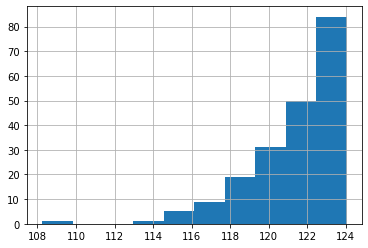

In [89]:
## Airfoil RF

PDs = pd.read_csv('./2022-07-16_airfoil_RF_0.85Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [90]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.05, 9, num_taus)

jackknife_plus_probs_ALL_airRF = []
split_probs_ALL_airRF = []
CV_probs_ALL_airRF = []
JAW_probs_ALL_airRF = []
correctness_ALL_airRF = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_airRF.append(jackknife_plus_probs_itrial)
    split_probs_ALL_airRF.append(split_probs_itrial)
    CV_probs_ALL_airRF.append(CV_probs_itrial)
    JAW_probs_ALL_airRF.append(JAW_probs_itrial)
    correctness_ALL_airRF.append(correctness_itrial)
            



  0%|                                                    | 0/20 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

## Calculate AUC


AUCs_jackknife_plus_ALL_airRF = []
AUCs_split_ALL_airRF = []
AUCs_CV_ALL_airRF = []
AUCs_JAW_ALL_airRF = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_airRF[itrial]
    split_probs_itrial = split_probs_ALL_airRF[itrial]
    CV_probs_itrial = CV_probs_ALL_airRF[itrial]
    JAW_probs_itrial = JAW_probs_ALL_airRF[itrial]
    correctness_itrial = correctness_ALL_airRF[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_airRF.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_airRF.append(AUCs_split_itrial)
    AUCs_CV_ALL_airRF.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_airRF.append(AUCs_JAW_itrial)
    
pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_airRF, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_airRF, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_airRF, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_airRF, axis = 0)}).to_csv('20220717_AUC_airfoil_RF_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_airRF, axis = 0), label = "Split conformal")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_airRF, axis = 0), label = "Jackknife+")
plt.plot(taus, np.mean(AUCs_CV_ALL_airRF, axis = 0), label = "CV+")
plt.plot(taus, np.mean(AUCs_JAW_ALL_airRF, axis = 0), label = "JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Tolerance', fontsize = 12)
plt.title('Airfoil dataset, random forest $\widehat{\mu}$ \nbeta = (-0.85, 0, 0, 0, 0.85)', fontsize = 14)
# plt.legend(loc=(1.04,0), ncol=7)
plt.savefig('20220717_AUC_airfoil_RF_corrected.png')
plt.show()


### Airfoil NN

In [ ]:
PDs = pd.read_csv('./2022-07-16_airfoil_NN_0.85Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [ ]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.05, 9, num_taus)

jackknife_plus_probs_ALL_airNN = []
split_probs_ALL_airNN = []
CV_probs_ALL_airNN = []
JAW_probs_ALL_airNN = []
correctness_ALL_airNN = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_airNN.append(jackknife_plus_probs_itrial)
    split_probs_ALL_airNN.append(split_probs_itrial)
    CV_probs_ALL_airNN.append(CV_probs_itrial)
    JAW_probs_ALL_airNN.append(JAW_probs_itrial)
    correctness_ALL_airNN.append(correctness_itrial)
            



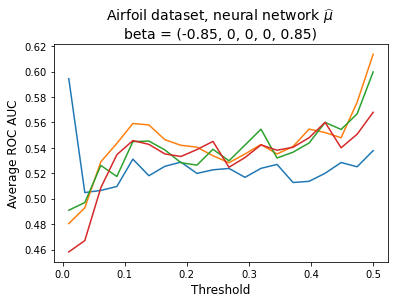

In [76]:

## Calculate AUC


AUCs_jackknife_plus_ALL_airNN = []
AUCs_split_ALL_airNN = []
AUCs_CV_ALL_airNN = []
AUCs_JAW_ALL_airNN = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_airNN[itrial]
    split_probs_itrial = split_probs_ALL_airNN[itrial]
    CV_probs_itrial = CV_probs_ALL_airNN[itrial]
    JAW_probs_itrial = JAW_probs_ALL_airNN[itrial]
    correctness_itrial = correctness_ALL_airNN[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_airNN.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_airNN.append(AUCs_split_itrial)
    AUCs_CV_ALL_airNN.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_airNN.append(AUCs_JAW_itrial)
    
pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_airNN, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_airNN, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_airNN, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_airNN, axis = 0)}).to_csv('20220717_AUC_airfoil_NN_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_airNN, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_airNN, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_airNN, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_airNN, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('Airfoil dataset, neural network $\widehat{\mu}$ \nbeta = (-0.85, 0, 0, 0, 0.85)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_airfoil_NN_corrected.png')
plt.show()


## Wine NN mu

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

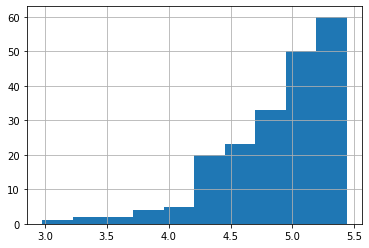

In [49]:
PDs = pd.read_csv('./2022-07-16_wine_NN_0.53Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [50]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.05, 2, num_taus)

jackknife_plus_probs_ALL_wineNN = []
split_probs_ALL_wineNN = []
CV_probs_ALL_wineNN = []
JAW_probs_ALL_wineNN = []
correctness_ALL_wineNN = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_wineNN.append(jackknife_plus_probs_itrial)
    split_probs_ALL_wineNN.append(split_probs_itrial)
    CV_probs_ALL_wineNN.append(CV_probs_itrial)
    JAW_probs_ALL_wineNN.append(JAW_probs_itrial)
    correctness_ALL_wineNN.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]


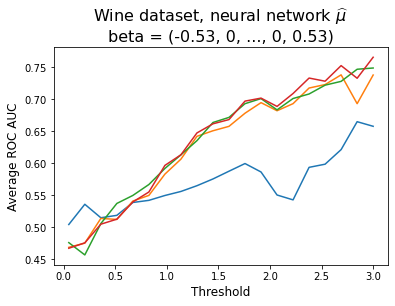

[0.50465642 0.53627577 0.5152117  0.51898282 0.53908107 0.54239891
 0.54998967 0.55629963 0.5652777  0.5758266  0.58793664 0.59990403
 0.58672467 0.55076814 0.54313527 0.59396882 0.5988941  0.62168594
 0.6652893  0.658104  ]
[0.46898237 0.47555337 0.51415059 0.51260429 0.54131159 0.55014134
 0.58337867 0.60677785 0.64244107 0.65112725 0.65801509 0.67853728
 0.69505407 0.68240318 0.69347977 0.71788461 0.72328243 0.73846864
 0.69344201 0.73820822]
[0.4763432  0.45715015 0.50612158 0.53757332 0.55010137 0.56715354
 0.5922177  0.61357773 0.6356668  0.66404098 0.67199464 0.69342957
 0.70137793 0.68376506 0.70150416 0.70858828 0.72238165 0.72829233
 0.74722137 0.74917089]
[0.4675655  0.47600999 0.50516328 0.51297726 0.5399222  0.55543589
 0.59701997 0.61355694 0.64773239 0.66197867 0.66858931 0.69745445
 0.70211638 0.68916518 0.70932635 0.73347345 0.72855669 0.75289926
 0.73316361 0.76598539]


In [77]:

## Calculate AUC
num_taus = 20
taus = np.linspace(0.05, 3, num_taus)

AUCs_jackknife_plus_ALL_wineNN = []
AUCs_split_ALL_wineNN = []
AUCs_CV_ALL_wineNN = []
AUCs_JAW_ALL_wineNN = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_wineNN[itrial]
    split_probs_itrial = split_probs_ALL_wineNN[itrial]
    CV_probs_itrial = CV_probs_ALL_wineNN[itrial]
    JAW_probs_itrial = JAW_probs_ALL_wineNN[itrial]
    correctness_itrial = correctness_ALL_wineNN[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_wineNN.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_wineNN.append(AUCs_split_itrial)
    AUCs_CV_ALL_wineNN.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_wineNN.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_wineNN, axis = 0), np.mean(AUCs_jackknife_plus_ALL_wineNN, axis = 0), np.mean(AUCs_CV_ALL_wineNN, axis = 0), np.mean(AUCs_JAW_ALL_wineNN, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wine_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_wineNN, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_wineNN, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_wineNN, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_wineNN, axis = 0)}).to_csv('20220717_AUC_wine_NN_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus[0:21], np.mean(AUCs_split_ALL_wineNN, axis = 0)[0:21], label = "AUCs_split")
plt.plot(taus[0:21], np.mean(AUCs_jackknife_plus_ALL_wineNN, axis = 0)[0:21], label = "AUCs_jackknife_plus")
plt.plot(taus[0:21], np.mean(AUCs_CV_ALL_wineNN, axis = 0)[0:21], label = "AUCs_CV")
plt.plot(taus[0:21], np.mean(AUCs_JAW_ALL_wineNN, axis = 0)[0:21], label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('Wine dataset, neural network $\widehat{\mu}$ \nbeta = (-0.53, 0, ..., 0, 0.53)', fontsize = 16)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_wine_NN_corrected.png')
plt.show()

print(np.mean(AUCs_split_ALL_wineNN, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_wineNN, axis = 0))
print(np.mean(AUCs_CV_ALL_wineNN, axis = 0))
print(np.mean(AUCs_JAW_ALL_wineNN, axis = 0))

## Wine RF

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

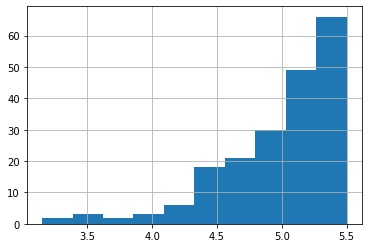

In [52]:
PDs = pd.read_csv('./2022-07-16_wine_RF_0.53Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [53]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.05, 2, num_taus)

jackknife_plus_probs_ALL_wineRF = []
split_probs_ALL_wineRF = []
CV_probs_ALL_wineRF = []
JAW_probs_ALL_wineRF = []
correctness_ALL_wineRF = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_wineRF.append(jackknife_plus_probs_itrial)
    split_probs_ALL_wineRF.append(split_probs_itrial)
    CV_probs_ALL_wineRF.append(CV_probs_itrial)
    JAW_probs_ALL_wineRF.append(JAW_probs_itrial)
    correctness_ALL_wineRF.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:12<00:00,  6.63s/it]


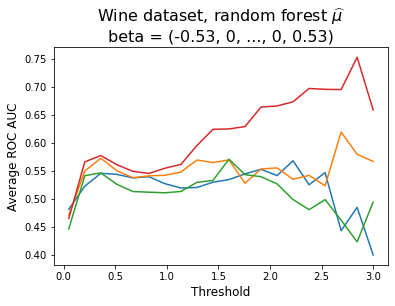

[0.48126294 0.52248483 0.54553941 0.54359054 0.53731826 0.53941183
 0.52695071 0.51922347 0.52011162 0.52955316 0.53427537 0.54456247
 0.5525811  0.54144264 0.56789123 0.52502163 0.54676518 0.44287565
 0.4845522  0.39950269]
[0.4704951  0.54961557 0.57231851 0.55012    0.53759945 0.54097511
 0.54190181 0.5477503  0.56916461 0.56482809 0.56947103 0.52774253
 0.55330394 0.55514528 0.53483941 0.54181927 0.5230782  0.61936287
 0.57948529 0.56661355]
[0.44624121 0.54124379 0.54621874 0.5257996  0.51294309 0.51172201
 0.51064763 0.51300659 0.52931999 0.53277801 0.57072039 0.5430533
 0.53945479 0.52659711 0.49855644 0.48038551 0.49841193 0.46179708
 0.42279649 0.49408365]
[0.4646792  0.5659563  0.5772704  0.56079897 0.54914223 0.54522015
 0.55457651 0.56131752 0.59531139 0.6241378  0.62486322 0.62911529
 0.6640184  0.66597653 0.67344334 0.69727494 0.69574879 0.69530322
 0.75312072 0.65890494]


In [78]:

## Calculate AUC


AUCs_jackknife_plus_ALL_wineRF = []
AUCs_split_ALL_wineRF = []
AUCs_CV_ALL_wineRF = []
AUCs_JAW_ALL_wineRF = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_wineRF[itrial]
    split_probs_itrial = split_probs_ALL_wineRF[itrial]
    CV_probs_itrial = CV_probs_ALL_wineRF[itrial]
    JAW_probs_itrial = JAW_probs_ALL_wineRF[itrial]
    correctness_itrial = correctness_ALL_wineRF[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_wineRF.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_wineRF.append(AUCs_split_itrial)
    AUCs_CV_ALL_wineRF.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_wineRF.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_wineRF, axis = 0), np.mean(AUCs_jackknife_plus_ALL_wineRF, axis = 0), np.mean(AUCs_CV_ALL_wineRF, axis = 0), np.mean(AUCs_JAW_ALL_wineRF, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wine_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_wineRF, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_wineRF, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_wineRF, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_wineRF, axis = 0)}).to_csv('20220717_AUC_wine_RF_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_wineRF, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_wineRF, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_wineRF, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_wineRF, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('Wine dataset, random forest $\widehat{\mu}$ \nbeta = (-0.53, 0, ..., 0, 0.53)', fontsize = 16)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_wine_RF_corrected.png')

plt.show()

print(np.mean(AUCs_split_ALL_wineRF, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_wineRF, axis = 0))
print(np.mean(AUCs_CV_ALL_wineRF, axis = 0))
print(np.mean(AUCs_JAW_ALL_wineRF, axis = 0))

## Wave RF

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

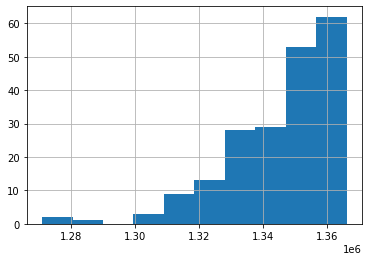

In [55]:
PDs = pd.read_csv('./2022-07-16_wave_RF_9.25e-05Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [56]:
## Calculate AUC

num_taus = 20

taus = np.linspace(1000, 40000, num_taus)

jackknife_plus_probs_ALL_waveRF = []
split_probs_ALL_waveRF = []
CV_probs_ALL_waveRF = []
JAW_probs_ALL_waveRF = []
correctness_ALL_waveRF = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_waveRF.append(jackknife_plus_probs_itrial)
    split_probs_ALL_waveRF.append(split_probs_itrial)
    CV_probs_ALL_waveRF.append(CV_probs_itrial)
    JAW_probs_ALL_waveRF.append(JAW_probs_itrial)
    correctness_ALL_waveRF.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:00<00:00,  6.03s/it]


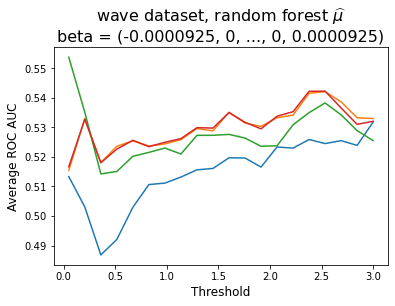

[0.51334673 0.50306439 0.48682597 0.49206471 0.50296771 0.51064891
 0.5111532  0.5131917  0.51564368 0.51611042 0.51971988 0.51964718
 0.51658522 0.52337429 0.52299546 0.52591312 0.52453389 0.52552666
 0.52392112 0.53181689]
[0.51546795 0.53299464 0.51805959 0.52363165 0.52544374 0.52373325
 0.52441809 0.52586772 0.52964315 0.52883929 0.53514112 0.53150409
 0.53032833 0.53328697 0.53417854 0.54157509 0.54212371 0.53865514
 0.53327207 0.53301481]
[0.55377408 0.53510039 0.514263   0.51508771 0.52022122 0.52155533
 0.52302156 0.52100169 0.52731861 0.52733808 0.52764277 0.52640741
 0.52362508 0.52378645 0.53089954 0.53502215 0.53829298 0.53426253
 0.52891523 0.52553208]
[0.51665702 0.5328004  0.51804329 0.52265939 0.52564432 0.52347903
 0.52498029 0.52620647 0.52992311 0.52978521 0.53503471 0.53174139
 0.52952064 0.53380699 0.53533439 0.54223805 0.54229504 0.53659912
 0.5310355  0.53208733]


In [79]:

## Calculate AUC


AUCs_jackknife_plus_ALL_waveRF = []
AUCs_split_ALL_waveRF = []
AUCs_CV_ALL_waveRF = []
AUCs_JAW_ALL_waveRF = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_waveRF[itrial]
    split_probs_itrial = split_probs_ALL_waveRF[itrial]
    CV_probs_itrial = CV_probs_ALL_waveRF[itrial]
    JAW_probs_itrial = JAW_probs_ALL_waveRF[itrial]
    correctness_itrial = correctness_ALL_waveRF[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_waveRF.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_waveRF.append(AUCs_split_itrial)
    AUCs_CV_ALL_waveRF.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_waveRF.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_waveRF, axis = 0), np.mean(AUCs_jackknife_plus_ALL_waveRF, axis = 0), np.mean(AUCs_CV_ALL_waveRF, axis = 0), np.mean(AUCs_JAW_ALL_waveRF, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wave_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_waveRF, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_waveRF, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_waveRF, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_waveRF, axis = 0)}).to_csv('20220717_AUC_wave_RF_data.csv')


plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_waveRF, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_waveRF, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_waveRF, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_waveRF, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('wave dataset, random forest $\widehat{\mu}$ \nbeta = (-0.0000925, 0, ..., 0, 0.0000925)', fontsize = 16)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_wave_RF_corrected.png')

plt.show()

print(np.mean(AUCs_split_ALL_waveRF, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_waveRF, axis = 0))
print(np.mean(AUCs_CV_ALL_waveRF, axis = 0))
print(np.mean(AUCs_JAW_ALL_waveRF, axis = 0))

## Wave NN

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

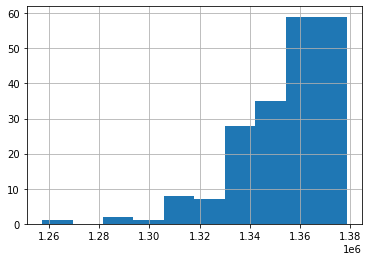

In [58]:
PDs = pd.read_csv('./2022-07-16_wave_NN_9.25e-05Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [59]:
## Calculate AUC

num_taus = 20

taus = np.linspace(1000, 40000, num_taus)

jackknife_plus_probs_ALL_waveNN = []
split_probs_ALL_waveNN = []
CV_probs_ALL_waveNN = []
JAW_probs_ALL_waveNN = []
correctness_ALL_waveNN = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_waveNN.append(jackknife_plus_probs_itrial)
    split_probs_ALL_waveNN.append(split_probs_itrial)
    CV_probs_ALL_waveNN.append(CV_probs_itrial)
    JAW_probs_ALL_waveNN.append(JAW_probs_itrial)
    correctness_ALL_waveNN.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:26<00:00,  7.34s/it]


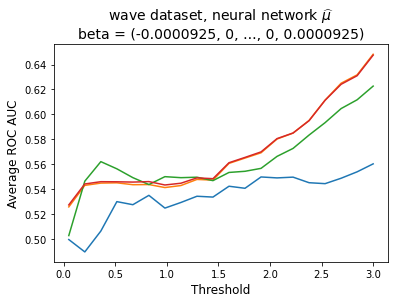

[0.49944713 0.4895067  0.50625626 0.52990113 0.52744219 0.53495327
 0.52471623 0.5292304  0.53422541 0.5335633  0.54226968 0.54063005
 0.54972807 0.54896914 0.54957841 0.54510295 0.54434654 0.54869531
 0.55385804 0.56024852]
[0.52565575 0.5429593  0.54478812 0.54501172 0.54350415 0.54363054
 0.54120984 0.54283556 0.54773812 0.54719482 0.56062794 0.56489683
 0.56913457 0.58019821 0.58496631 0.59514734 0.61144508 0.62503998
 0.63174775 0.64831022]
[0.50262866 0.54634641 0.56203185 0.55626538 0.54916507 0.54361596
 0.54996497 0.54915266 0.5495216  0.54677246 0.55334962 0.55427832
 0.55662952 0.56625723 0.57265718 0.58339616 0.59336003 0.60466079
 0.61172592 0.6227167 ]
[0.52727484 0.54410958 0.54592199 0.54584629 0.54560559 0.54600502
 0.54327469 0.54469351 0.54898773 0.54833799 0.56115517 0.56542648
 0.56985372 0.5805407  0.58503932 0.5949356  0.6113372  0.62416846
 0.63106114 0.64758035]


In [92]:

## Calculate AUC
num_taus = 20
taus = np.linspace(0.05, 3, num_taus)

AUCs_jackknife_plus_ALL_waveNN = []
AUCs_split_ALL_waveNN = []
AUCs_CV_ALL_waveNN = []
AUCs_JAW_ALL_waveNN = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_waveNN[itrial]
    split_probs_itrial = split_probs_ALL_waveNN[itrial]
    CV_probs_itrial = CV_probs_ALL_waveNN[itrial]
    JAW_probs_itrial = JAW_probs_ALL_waveNN[itrial]
    correctness_itrial = correctness_ALL_waveNN[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_waveNN.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_waveNN.append(AUCs_split_itrial)
    AUCs_CV_ALL_waveNN.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_waveNN.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_waveNN, axis = 0), np.mean(AUCs_jackknife_plus_ALL_waveNN, axis = 0), np.mean(AUCs_CV_ALL_waveNN, axis = 0), np.mean(AUCs_JAW_ALL_waveNN, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wave_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_waveNN, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_waveNN, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_waveNN, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_waveNN, axis = 0)}).to_csv('20220717_AUC_wave_NN_data.csv')

# plt.figure(figsize=(6,6))
plt.plot(taus[0:21], np.mean(AUCs_split_ALL_waveNN, axis = 0)[0:21], label = "AUCs_split")
plt.plot(taus[0:21], np.mean(AUCs_jackknife_plus_ALL_waveNN, axis = 0)[0:21], label = "AUCs_jackknife_plus")
plt.plot(taus[0:21], np.mean(AUCs_CV_ALL_waveNN, axis = 0)[0:21], label = "AUCs_CV")
plt.plot(taus[0:21], np.mean(AUCs_JAW_ALL_waveNN, axis = 0)[0:21], label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('wave dataset, neural network $\widehat{\mu}$ \nbeta = (-0.0000925, 0, ..., 0, 0.0000925)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_wave_NN_corrected.png')
plt.show()

print(np.mean(AUCs_split_ALL_waveNN, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_waveNN, axis = 0))
print(np.mean(AUCs_CV_ALL_waveNN, axis = 0))
print(np.mean(AUCs_JAW_ALL_waveNN, axis = 0))

## Superconduct RF

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

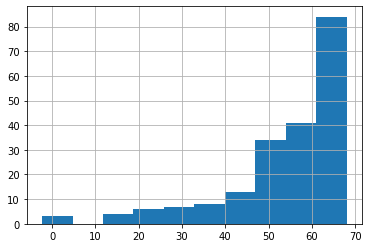

In [61]:
PDs = pd.read_csv('./2022-07-16_superconduct_RF_0.00062Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [62]:
## Calculate AUC

num_taus = 20

taus = np.linspace(1, 40, num_taus)

jackknife_plus_probs_ALL_superconductRF = []
split_probs_ALL_superconductRF = []
CV_probs_ALL_superconductRF = []
JAW_probs_ALL_superconductRF = []
correctness_ALL_superconductRF = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_superconductRF.append(jackknife_plus_probs_itrial)
    split_probs_ALL_superconductRF.append(split_probs_itrial)
    CV_probs_ALL_superconductRF.append(CV_probs_itrial)
    JAW_probs_ALL_superconductRF.append(JAW_probs_itrial)
    correctness_ALL_superconductRF.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:47<00:00,  8.36s/it]


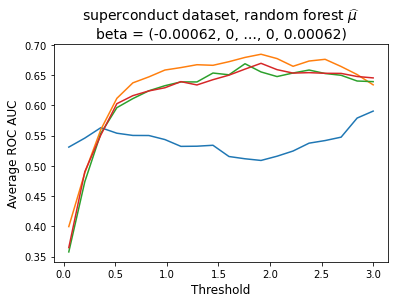

[0.5309307  0.54584095 0.56306247 0.55392355 0.55023031 0.55009749
 0.54340654 0.53214402 0.53241987 0.53397105 0.51536736 0.51163706
 0.50887604 0.51587467 0.52446287 0.53746337 0.54176334 0.54739689
 0.57897897 0.59046915]
[0.39945165 0.48845568 0.55993441 0.6115756  0.63720103 0.64709315
 0.65839848 0.66246534 0.66719147 0.66622681 0.67221733 0.67925365
 0.68451632 0.6773461  0.66458934 0.67328614 0.67613776 0.66422938
 0.65093037 0.63391471]
[0.35759112 0.47373746 0.55354717 0.59615672 0.6111474  0.62410525
 0.63249082 0.63876884 0.63871539 0.65344585 0.65052868 0.66882873
 0.65524454 0.64760046 0.65351525 0.65839478 0.65266271 0.64972675
 0.64024848 0.63920944]
[0.36468771 0.49023975 0.55095744 0.60275446 0.61603466 0.62387039
 0.62908513 0.63920938 0.63373549 0.6424306  0.64993651 0.65993577
 0.66950463 0.65903657 0.653343   0.65407985 0.65300239 0.65282759
 0.64770115 0.64538831]


In [86]:

## Calculate AUC


AUCs_jackknife_plus_ALL_superconductRF = []
AUCs_split_ALL_superconductRF = []
AUCs_CV_ALL_superconductRF = []
AUCs_JAW_ALL_superconductRF = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_superconductRF[itrial]
    split_probs_itrial = split_probs_ALL_superconductRF[itrial]
    CV_probs_itrial = CV_probs_ALL_superconductRF[itrial]
    JAW_probs_itrial = JAW_probs_ALL_superconductRF[itrial]
    correctness_itrial = correctness_ALL_superconductRF[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_superconductRF.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_superconductRF.append(AUCs_split_itrial)
    AUCs_CV_ALL_superconductRF.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_superconductRF.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_superconductRF, axis = 0), np.mean(AUCs_jackknife_plus_ALL_superconductRF, axis = 0), np.mean(AUCs_CV_ALL_superconductRF, axis = 0), np.mean(AUCs_JAW_ALL_superconductRF, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_superconduct_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_superconductRF, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_superconductRF, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_superconductRF, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_superconductRF, axis = 0)}).to_csv('20220717_AUC_superconduct_RF_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_superconductRF, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_superconductRF, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_superconductRF, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_superconductRF, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('superconduct dataset, random forest $\widehat{\mu}$ \nbeta = (-0.00062, 0, ..., 0, 0.00062)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_superconduct_RF_corrected.png')

plt.show()

print(np.mean(AUCs_split_ALL_superconductRF, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_superconductRF, axis = 0))
print(np.mean(AUCs_CV_ALL_superconductRF, axis = 0))
print(np.mean(AUCs_JAW_ALL_superconductRF, axis = 0))

## Superconduct NN

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

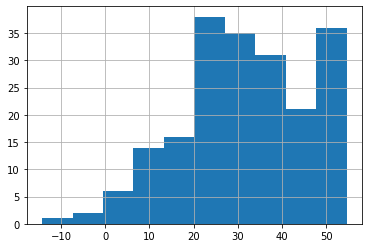

In [64]:
PDs = pd.read_csv('./2022-07-16_superconduct_NN_0.00062Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower0'].hist())

In [65]:
## Calculate AUC

num_taus = 20

taus = np.linspace(1, 40, num_taus)

jackknife_plus_probs_ALL_superconductNN = []
split_probs_ALL_superconductNN = []
CV_probs_ALL_superconductNN = []
JAW_probs_ALL_superconductNN = []
correctness_ALL_superconductNN = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_superconductNN.append(jackknife_plus_probs_itrial)
    split_probs_ALL_superconductNN.append(split_probs_itrial)
    CV_probs_ALL_superconductNN.append(CV_probs_itrial)
    JAW_probs_ALL_superconductNN.append(JAW_probs_itrial)
    correctness_ALL_superconductNN.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:39<00:00,  7.97s/it]


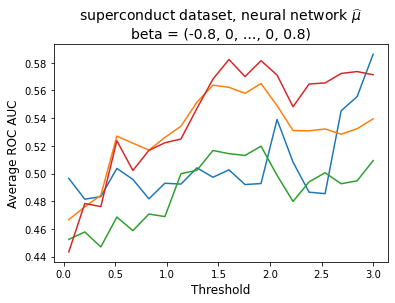

[0.49650991 0.48150837 0.48338019 0.50374112 0.49581998 0.48178561
 0.49303327 0.4924135  0.5041202  0.4973654  0.50268558 0.49208333
 0.49280803 0.53904656 0.50823494 0.48655034 0.48553185 0.54532398
 0.55558515 0.58616311]
[0.46676009 0.4759953  0.48433087 0.52705811 0.52192016 0.51692696
 0.52610722 0.53418928 0.55153787 0.56383619 0.56229096 0.55793265
 0.56502067 0.54909102 0.53105916 0.53087161 0.53220087 0.52844702
 0.53242628 0.53949482]
[0.45248931 0.4578673  0.44702418 0.46862211 0.45879328 0.47078286
 0.46894357 0.49990079 0.50241706 0.51667914 0.51437691 0.51309919
 0.51977484 0.49876288 0.47986045 0.49401233 0.50060581 0.49268573
 0.49478589 0.50937338]
[0.44344473 0.47840388 0.47617965 0.52374769 0.50224362 0.51674144
 0.52226888 0.52494447 0.54709123 0.56824398 0.58238094 0.57001551
 0.58150908 0.5711517  0.54824367 0.56467565 0.56546028 0.57227079
 0.57365836 0.57134429]


In [85]:

## Calculate AUC
num_taus = 20
taus = np.linspace(0.05, 3, num_taus)

AUCs_jackknife_plus_ALL_superconductNN = []
AUCs_split_ALL_superconductNN = []
AUCs_CV_ALL_superconductNN = []
AUCs_JAW_ALL_superconductNN = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_superconductNN[itrial]
    split_probs_itrial = split_probs_ALL_superconductNN[itrial]
    CV_probs_itrial = CV_probs_ALL_superconductNN[itrial]
    JAW_probs_itrial = JAW_probs_ALL_superconductNN[itrial]
    correctness_itrial = correctness_ALL_superconductNN[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_superconductNN.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_superconductNN.append(AUCs_split_itrial)
    AUCs_CV_ALL_superconductNN.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_superconductNN.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_superconductNN, axis = 0), np.mean(AUCs_jackknife_plus_ALL_superconductNN, axis = 0), np.mean(AUCs_CV_ALL_superconductNN, axis = 0), np.mean(AUCs_JAW_ALL_superconductNN, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_superconduct_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_superconductNN, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_superconductNN, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_superconductNN, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_superconductNN, axis = 0)}).to_csv('20220717_AUC_superconduct_NN_data.csv')


plt.figure(figsize=(6,6))
plt.plot(taus[0:21], np.mean(AUCs_split_ALL_superconductNN, axis = 0)[0:21], label = "AUCs_split")
plt.plot(taus[0:21], np.mean(AUCs_jackknife_plus_ALL_superconductNN, axis = 0)[0:21], label = "AUCs_jackknife_plus")
plt.plot(taus[0:21], np.mean(AUCs_CV_ALL_superconductNN, axis = 0)[0:21], label = "AUCs_CV")
plt.plot(taus[0:21], np.mean(AUCs_JAW_ALL_superconductNN, axis = 0)[0:21], label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('superconduct dataset, neural network $\widehat{\mu}$ \nbeta = (-0.8, 0, ..., 0, 0.8)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_superconduct_NN_corrected.png')
plt.show()

print(np.mean(AUCs_split_ALL_superconductNN, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_superconductNN, axis = 0))
print(np.mean(AUCs_CV_ALL_superconductNN, axis = 0))
print(np.mean(AUCs_JAW_ALL_superconductNN, axis = 0))

## Communities RF

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

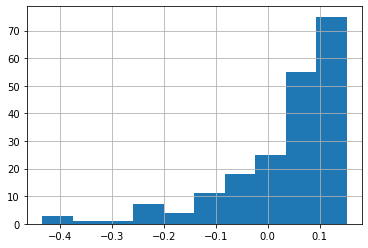

In [67]:
PDs = pd.read_csv('./2022-07-16_communities_RF_0.825Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower1'].hist())

In [69]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.01, 0.5, num_taus)

jackknife_plus_probs_ALL_comRF = []
split_probs_ALL_comRF = []
CV_probs_ALL_comRF = []
JAW_probs_ALL_comRF = []
correctness_ALL_comRF = []


for itrial in set(PDs['itrial']):
# for itrial in [0]:
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_comRF.append(jackknife_plus_probs_itrial)
    split_probs_ALL_comRF.append(split_probs_itrial)
    CV_probs_ALL_comRF.append(CV_probs_itrial)
    JAW_probs_ALL_comRF.append(JAW_probs_itrial)
    correctness_ALL_comRF.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:21<00:00,  7.06s/it]


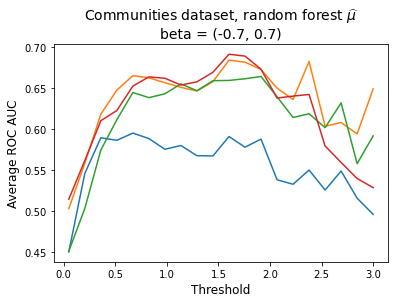

[0.45064627 0.54626858 0.58972965 0.58665015 0.59544742 0.58877283
 0.57573507 0.58031115 0.5678984  0.56763705 0.59126023 0.5782624
 0.58813229 0.53857102 0.53310703 0.55039622 0.52609193 0.54920047
 0.51613143 0.49636017]
[0.50336424 0.55869785 0.6184289  0.64777855 0.66545476 0.66283255
 0.6567718  0.65116555 0.64672695 0.65807116 0.68438001 0.681899
 0.67298949 0.65023632 0.63645194 0.68276339 0.6037379  0.60836064
 0.59443655 0.64926133]
[0.4514933  0.50357368 0.57479053 0.61173122 0.64495506 0.63864005
 0.64334791 0.65541008 0.64708482 0.65929625 0.65962646 0.66164974
 0.66443408 0.63976911 0.61445909 0.61904813 0.60212964 0.63226131
 0.55824008 0.59206242]
[0.51488714 0.561984   0.61049275 0.62297267 0.65272908 0.66392259
 0.66228279 0.65399934 0.65791368 0.66964507 0.69153676 0.68926044
 0.67327908 0.63815841 0.64054567 0.64249113 0.57978914 0.55966177
 0.5401053  0.52899571]


In [84]:

## Calculate AUC


AUCs_jackknife_plus_ALL_comRF = []
AUCs_split_ALL_comRF = []
AUCs_CV_ALL_comRF = []
AUCs_JAW_ALL_comRF = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_comRF[itrial]
    split_probs_itrial = split_probs_ALL_comRF[itrial]
    CV_probs_itrial = CV_probs_ALL_comRF[itrial]
    JAW_probs_itrial = JAW_probs_ALL_comRF[itrial]
    correctness_itrial = correctness_ALL_comRF[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_comRF.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_comRF.append(AUCs_split_itrial)
    AUCs_CV_ALL_comRF.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_comRF.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_comRF, axis = 0), np.mean(AUCs_jackknife_plus_ALL_comRF, axis = 0), np.mean(AUCs_CV_ALL_comRF, axis = 0), np.mean(AUCs_JAW_ALL_comRF, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wine_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_comRF, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_comRF, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_comRF, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_comRF, axis = 0)}).to_csv('20220717_AUC_communities_RF_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_comRF, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_comRF, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_comRF, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_comRF, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('Communities dataset, random forest $\widehat{\mu}$ \nbeta = (-0.7, 0.7)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_communities_RF_corrected.png')

plt.show()

print(np.mean(AUCs_split_ALL_comRF, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_comRF, axis = 0))
print(np.mean(AUCs_CV_ALL_comRF, axis = 0))
print(np.mean(AUCs_JAW_ALL_comRF, axis = 0))

## Communities data NN

{'naive', 'split', 'weights_JAW_test', 'jackknife+_sorted', 'jackknife', 'any', 'CV+', 'weights_JAW_train', 'jackknife+_not_sorted', 'muh_vals_testpoint'}


<AxesSubplot:>

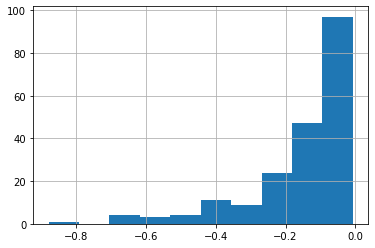

In [71]:
PDs = pd.read_csv('./2022-07-16_communities_NN_0.825Bias_5Trials_PDs.csv')
print(set(PDs['method']))
PDs_0 = PDs[PDs['itrial']==0]
PDs_0[PDs_0['method']=='jackknife+_sorted']

train_scores = list(PDs_0[PDs_0['method']=='jackknife+_sorted']['lower' + str(0)])
display(PDs_0[PDs_0['method']=='jackknife']['lower1'].hist())

In [72]:
## Calculate AUC

num_taus = 20

taus = np.linspace(0.01, 0.5, num_taus)

jackknife_plus_probs_ALL_comNN = []
split_probs_ALL_comNN = []
CV_probs_ALL_comNN = []
JAW_probs_ALL_comNN = []
correctness_ALL_comNN = []


# for itrial in set(PDs['itrial']):
for itrial in set(PDs['itrial']):
    PDs_itrial = PDs[PDs['itrial']==itrial]
    jackknife_plus_probs_itrial = []
    split_probs_itrial = []
    CV_probs_itrial = []
    JAW_probs_itrial = []
    correctness_itrial = []
    
    for tau in tqdm.tqdm(taus):
#         jackknife_probs = []
#         naive_probs = []
        jackknife_plus_probs = []
        split_probs = []
        CV_probs = []
        JAW_probs = []
        correctness = []
        for test_pt in range(0, 650):
            y_true = float(PDs_itrial[PDs_itrial['testpoint']==True]['lower' + str(test_pt)])
            y_pred = float(PDs_itrial[PDs_itrial['method']=='muh_vals_testpoint']['lower' + str(test_pt)])
            y_pred_lower = y_pred - tau
            y_pred_upper = y_pred + tau
            
#             jackknife_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife'))
#             naive_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'naive'))
            jackknife_plus_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'jackknife+_sorted'))
            split_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'split'))
            CV_probs.append(prob_interval_sorted_unweighted(y_pred_lower, y_pred_upper, test_pt, 'CV+'))
            JAW_probs.append(prob_interval_JAW(y_pred_lower, y_pred_upper, test_pt))
            correctness.append(y_pred_lower <= y_true and y_true <= y_pred_upper)
            
            
#         print("naive_probs : ", naive_probs)
#         print("jackknife_probs : ", jackknife_probs)
        jackknife_plus_probs_itrial.append(jackknife_plus_probs)
        split_probs_itrial.append(split_probs)
        CV_probs_itrial.append(CV_probs)
        JAW_probs_itrial.append(JAW_probs)
        correctness_itrial.append(correctness)
        
    jackknife_plus_probs_ALL_comNN.append(jackknife_plus_probs_itrial)
    split_probs_ALL_comNN.append(split_probs_itrial)
    CV_probs_ALL_comNN.append(CV_probs_itrial)
    JAW_probs_ALL_comNN.append(JAW_probs_itrial)
    correctness_ALL_comNN.append(correctness_itrial)
            



100%|███████████████████████████████████████████| 20/20 [02:15<00:00,  6.76s/it]


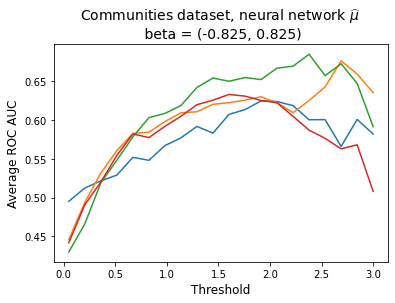

[0.4952336  0.51236315 0.52158818 0.52896918 0.55192947 0.54801671
 0.56699341 0.57692421 0.59171195 0.58306102 0.60716381 0.61335863
 0.62449957 0.62374542 0.61846968 0.6003123  0.60042449 0.56591928
 0.60065834 0.58192339]
[0.44583534 0.49378549 0.53174776 0.56040783 0.58274556 0.58425874
 0.59790979 0.60929818 0.61056743 0.62022367 0.62224064 0.62556323
 0.62986471 0.62230293 0.60949128 0.6250632  0.64256451 0.67607774
 0.65912329 0.63523624]
[0.43005621 0.46610013 0.5190697  0.54824668 0.57820828 0.60296346
 0.60845309 0.61860175 0.64189746 0.6539922  0.64986342 0.65464044
 0.65206847 0.66678007 0.66931656 0.68466661 0.65712321 0.67242588
 0.64705075 0.59135606]
[0.44190408 0.49079274 0.52015971 0.55433385 0.58196564 0.57734864
 0.59176497 0.60472054 0.61966141 0.62552208 0.63284495 0.6307052
 0.62517331 0.62210702 0.60471054 0.58687293 0.57633765 0.5628646
 0.5680212  0.50808555]


In [83]:

## Calculate AUC


AUCs_jackknife_plus_ALL_comNN = []
AUCs_split_ALL_comNN = []
AUCs_CV_ALL_comNN = []
AUCs_JAW_ALL_comNN = []

for itrial in set(PDs['itrial']):
    AUCs_jackknife_plus_itrial = []
    AUCs_split_itrial = []
    AUCs_CV_itrial = []
    AUCs_JAW_itrial = []

    jackknife_plus_probs_itrial = jackknife_plus_probs_ALL_comNN[itrial]
    split_probs_itrial = split_probs_ALL_comNN[itrial]
    CV_probs_itrial = CV_probs_ALL_comNN[itrial]
    JAW_probs_itrial = JAW_probs_ALL_comNN[itrial]
    correctness_itrial = correctness_ALL_comNN[itrial]
    
    for i in range(0, num_taus):
        correctness = correctness_itrial[i]
        AUCs_split_itrial.append(roc_auc_score(correctness, split_probs_itrial[i]))
        AUCs_CV_itrial.append(roc_auc_score(correctness, CV_probs_itrial[i]))
        AUCs_jackknife_plus_itrial.append(roc_auc_score(correctness, jackknife_plus_probs_itrial[i]))
        AUCs_JAW_itrial.append(roc_auc_score(correctness, JAW_probs_itrial[i]))
        
    AUCs_jackknife_plus_ALL_comNN.append(AUCs_jackknife_plus_itrial)
    AUCs_split_ALL_comNN.append(AUCs_split_itrial)
    AUCs_CV_ALL_comNN.append(AUCs_CV_itrial)
    AUCs_JAW_ALL_comNN.append(AUCs_JAW_itrial)
    
# col_names = ['taus', 'AUCs_split', 'AUCs_jackknife_plus', 'AUCs_CV', 'AUCs_JAW']
# AUCs_df = pd.DataFrame([taus, np.mean(AUCs_split_ALL_comNN, axis = 0), np.mean(AUCs_jackknife_plus_ALL_comNN, axis = 0), np.mean(AUCs_CV_ALL_comNN, axis = 0), np.mean(AUCs_JAW_ALL_comNN, axis = 0)], columns = col_names)
# AUCs_df.to_csv('20220519_AUCs_wine_NN')

pd.DataFrame({'taus': taus, 'split': np.mean(AUCs_split_ALL_comNN, axis = 0), 
     'jackknife+':np.mean(AUCs_jackknife_plus_ALL_comNN, axis = 0),
    'CV+':np.mean(AUCs_CV_ALL_comNN, axis = 0),
    'JAW':np.mean(AUCs_JAW_ALL_comNN, axis = 0)}).to_csv('20220717_AUC_communities_NN_data.csv')

plt.figure(figsize=(6,6))
plt.plot(taus, np.mean(AUCs_split_ALL_comNN, axis = 0), label = "AUCs_split")
plt.plot(taus, np.mean(AUCs_jackknife_plus_ALL_comNN, axis = 0), label = "AUCs_jackknife_plus")
plt.plot(taus, np.mean(AUCs_CV_ALL_comNN, axis = 0), label = "AUCs_CV")
plt.plot(taus, np.mean(AUCs_JAW_ALL_comNN, axis = 0), label = "AUCs_JAW")
plt.ylabel('Average ROC AUC', fontsize = 12)
plt.xlabel('Threshold', fontsize = 12)
plt.title('Communities dataset, neural network $\widehat{\mu}$ \n beta = (-0.825, 0.825)', fontsize = 14)
# plt.legend(loc=(1.04,0))
plt.savefig('20220717_AUC_communities_NN_corrected.png')

plt.show()

print(np.mean(AUCs_split_ALL_comNN, axis = 0))
print(np.mean(AUCs_jackknife_plus_ALL_comNN, axis = 0))
print(np.mean(AUCs_CV_ALL_comNN, axis = 0))
print(np.mean(AUCs_JAW_ALL_comNN, axis = 0))